In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

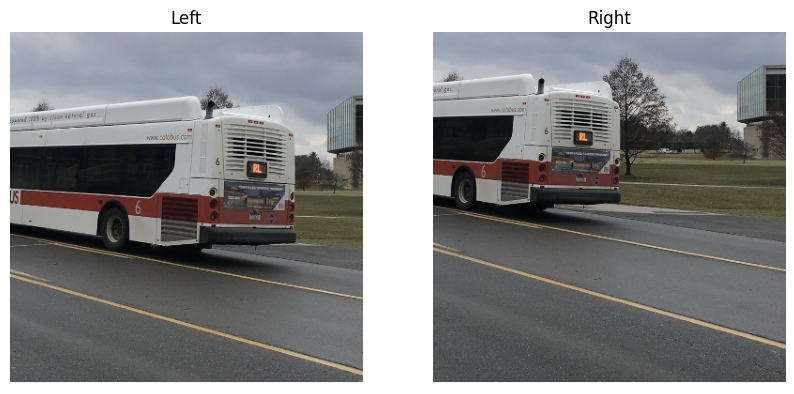

In [49]:
# 讀取圖像
# img1 = cv2.imread('C:\\ellie\\study\\data\\every_bone_similarity\\LS_noL2_cropped\\L4.png')
# img2 = cv2.imread('C:\\ellie\\study\\data\\every_bone_similarity\\LS_noL2_cropped\\S4.png')

img1 = cv2.imread('C:\ellie\study\data\\bus_left.png')
img2 = cv2.imread('C:\ellie\study\data\\bus_right.png')

if img1 is None:
    print("Error: L4.png not found or unable to load")
if img2 is None:
    print("Error: S4.png not found or unable to load")

# 將 BGR 圖像轉換為 RGB 以便使用 matplotlib 繪製
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# 繪製剪裁後的圖像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Left')
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Right')
plt.imshow(img2)
plt.axis('off')

plt.show()


In [50]:
#定義要拼接的左圖和右圖
left_img = img1
right_img = img2

#定義遮罩寬度
mask_width1 = 512
mask_width2 = 512

# 左圖遮罩對齊右邊
mask1 = np.zeros(left_img.shape[:2], dtype=np.uint8)
mask1[:, -mask_width1:] = 255

# 右圖遮罩對齊左邊
mask2 = np.zeros(right_img.shape[:2], dtype=np.uint8)
mask2[:, :mask_width2] = 255

### SIFT

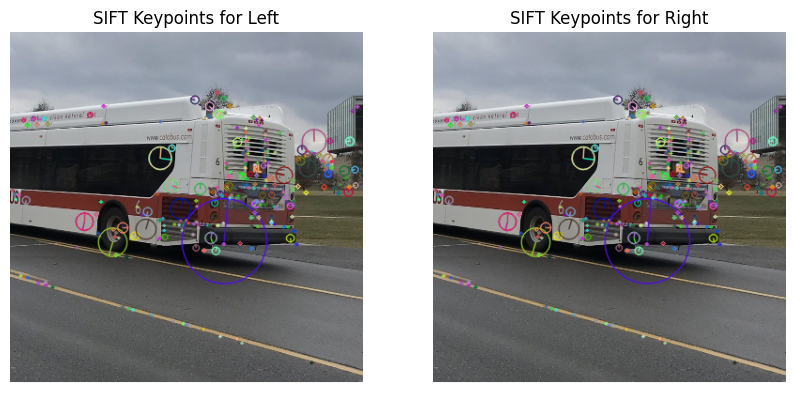

Number of good matches: 168


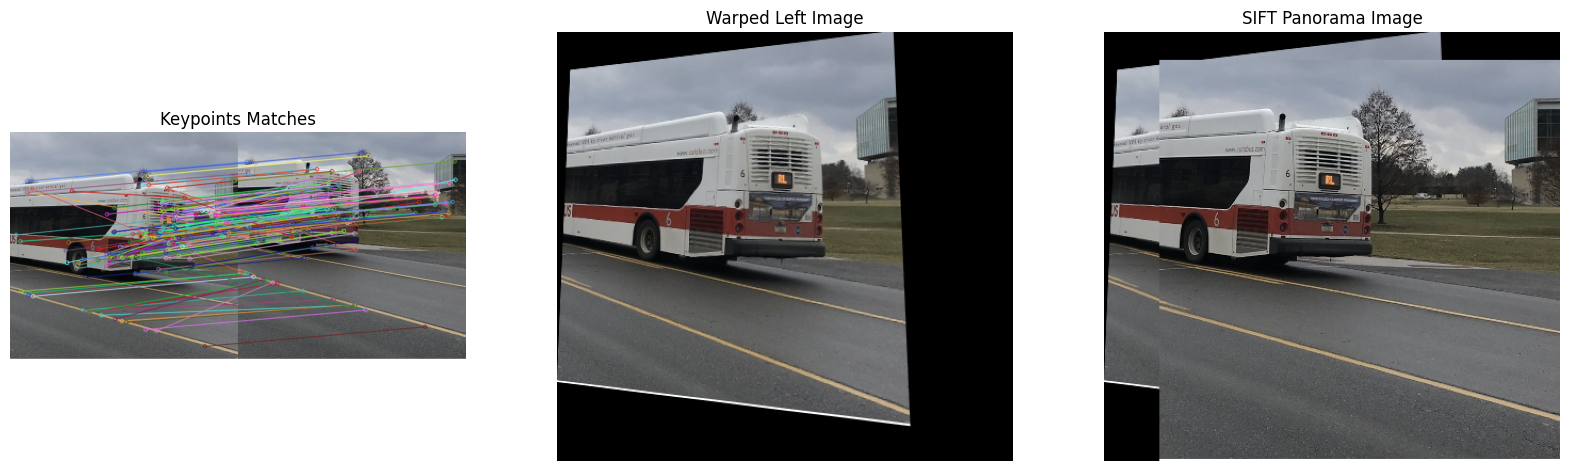

In [51]:
# 創建 SIFT 物件
sift = cv2.SIFT_create()

# 直接在整個圖像上提取 SIFT 特徵點和描述子
keypoints1_sift, descriptors1_sift = sift.detectAndCompute(left_img, None)
keypoints2_sift, descriptors2_sift = sift.detectAndCompute(right_img, None)

# 繪製單純 SIFT 特徵點
plt.figure(figsize=(10, 5))

left_img_with_keypoints_pure = cv2.drawKeypoints(left_img, keypoints1_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
right_img_with_keypoints_pure = cv2.drawKeypoints(right_img, keypoints2_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplot(1, 2, 1)
plt.title('SIFT Keypoints for Left')
plt.imshow(left_img_with_keypoints_pure)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('SIFT Keypoints for Right')
plt.imshow(left_img_with_keypoints_pure)
plt.axis('off')

plt.show()

# 提取特徵點和描述子
keypoints1, descriptors1 = keypoints1_sift, descriptors1_sift
keypoints2, descriptors2 = keypoints2_sift, descriptors2_sift

# 特徵匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# 只保留好的匹配
good_matches = []
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append(m)

# 檢查匹配數量
print(f'Number of good matches: {len(good_matches)}')

# 提取匹配點
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore

    # 使用 RANSAC 方法估計單應矩陣
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 計算變形後的圖像邊界
    left_img_h, left_img_w = left_img.shape[:2]
    right_img_h, right_img_w = right_img.shape[:2]
    corners_left = np.float32([[0, 0], [0, left_img_h], [left_img_w, left_img_h], [left_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_right = np.float32([[0, 0], [0, right_img_h], [right_img_w, right_img_h], [right_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_left_transformed = cv2.perspectiveTransform(corners_left, H)
    corners_combined = np.concatenate((corners_right, corners_left_transformed), axis=0)

    # 找到拼接圖像的邊界
    [xmin, ymin] = np.int32(corners_combined.min(axis=0).ravel() - 0.5) # type: ignore
    [xmax, ymax] = np.int32(corners_combined.max(axis=0).ravel() + 0.5) # type: ignore

    # 計算平移變換矩陣
    translation = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    
    # 將左圖變形並平移
    warped_left_img = cv2.warpPerspective(left_img, translation.dot(H), (xmax - xmin, ymax - ymin))

    # 將右圖放置在平移後的畫布上
    result_img = warped_left_img.copy()
    result_img[-ymin:right_img_h - ymin, -xmin:right_img_w - xmin] = right_img

    # 繪製匹配點
    matches_img = cv2.drawMatches(left_img, keypoints1, right_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # type: ignore

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title('Keypoints Matches')
    plt.imshow(matches_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Warped Left Image')
    plt.imshow(warped_left_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('SIFT Panorama Image')
    plt.imshow(result_img)
    plt.axis('off')

    plt.show()
else:
    print('Not enough good matches to compute homography.')

### Super Pixel + SIFT

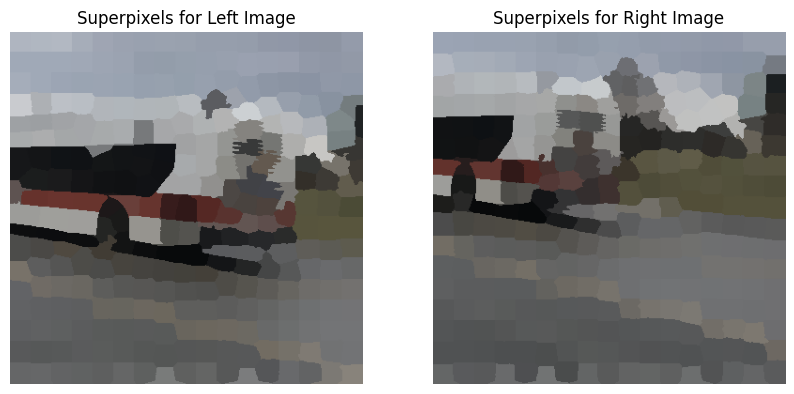

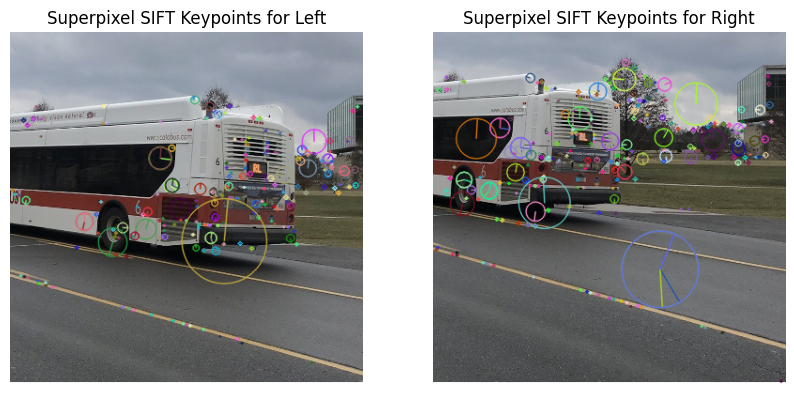

Number of good matches: 121


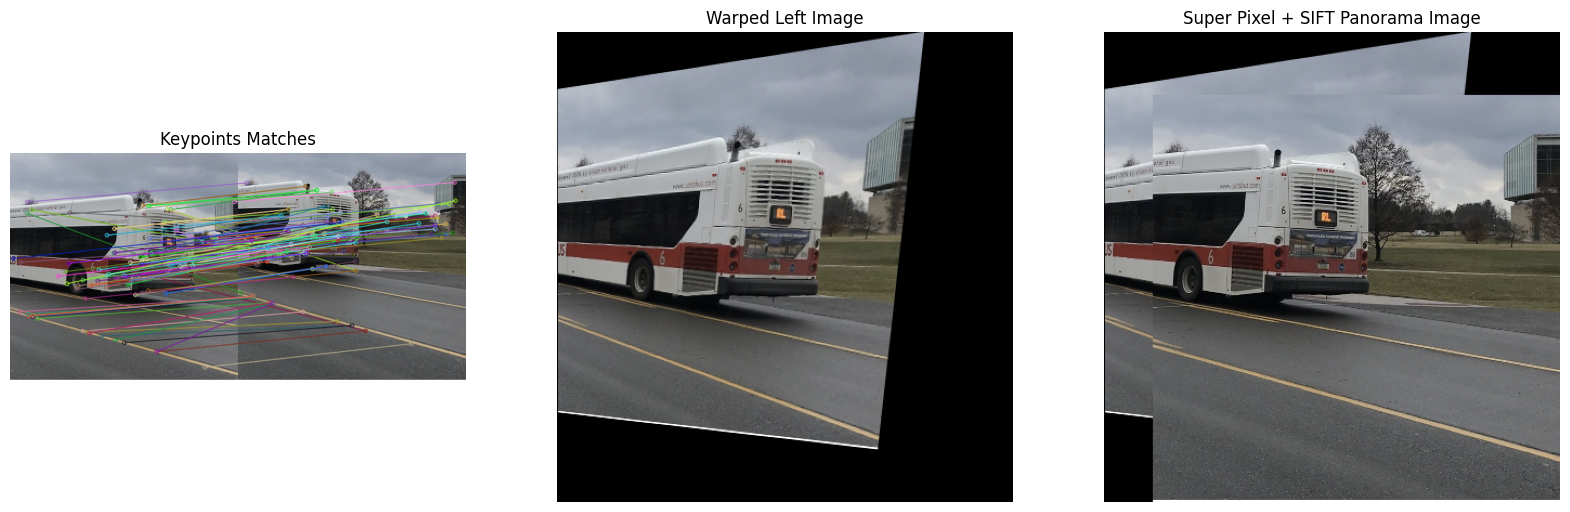

In [52]:
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage.color import label2rgb

# 轉換影像到浮點數格式，便於進行 SLIC 超像素分割
left_img_float = img_as_float(left_img)
right_img_float = img_as_float(right_img)

# 使用 SLIC 進行超像素分割，這裡設定每個超像素的大小為 100 個像素
segments_left = slic(left_img_float, n_segments=300, compactness=30, sigma=1)
segments_right = slic(right_img_float, n_segments=300, compactness=30, sigma=1)

# 將超像素區塊標籤轉換為可以視覺化的 RGB 格式
left_img_superpixel = label2rgb(segments_left, left_img, kind='avg')
right_img_superpixel = label2rgb(segments_right, right_img, kind='avg')

# 繪製超像素分割結果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Super Pixels Blocks for Left Image')
plt.imshow(left_img_superpixel)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Super Pixels Blocks for Right Image')
plt.imshow(right_img_superpixel)
plt.axis('off')

plt.show()

# 使用 SLIC 進行超像素分割後，在每個超像素區域內提取 SIFT 特徵點
keypoints1_sift_superpixel, descriptors1_sift_superpixel = [], []
keypoints2_sift_superpixel, descriptors2_sift_superpixel = [], []

# 在每個超像素區域內只保留特徵點響應值最高的幾個特徵點
for segment_label in np.unique(segments_left):
    mask_left = np.zeros(left_img.shape[:2], dtype=np.uint8)
    mask_left[segments_left == segment_label] = 255
    kp_left, des_left = sift.detectAndCompute(left_img, mask_left)
    
    # if des_left is not None:
    #     keypoints1_sift_superpixel.extend(kp_left)
    #     descriptors1_sift_superpixel.append(des_left)
    
    # 只保留響應值最高的特徵點
    if des_left is not None:
        sorted_kp_left = sorted(kp_left, key=lambda x: x.response, reverse=True)[:5]  # 保留每個區域內響應值最高的5個特徵點
        keypoints1_sift_superpixel.extend(sorted_kp_left)
        descriptors1_sift_superpixel.append(des_left[:5])  # 保留對應的描述子

for segment_label in np.unique(segments_right):
    mask_right = np.zeros(right_img.shape[:2], dtype=np.uint8)
    mask_right[segments_right == segment_label] = 255
    kp_right, des_right = sift.detectAndCompute(right_img, mask_right)
    
    # if des_right is not None:
    #     keypoints2_sift_superpixel.extend(kp_right)
    #     descriptors2_sift_superpixel.append(des_right)
    
    # 只保留響應值最高的特徵點
    if des_right is not None:
        sorted_kp_right = sorted(kp_right, key=lambda x: x.response, reverse=True)[:5]  # 保留每個區域內響應值最高的5個特徵點
        keypoints2_sift_superpixel.extend(sorted_kp_right)
        descriptors2_sift_superpixel.append(des_right[:5])  # 保留對應的描述子

# 合併描述子
if len(descriptors1_sift_superpixel) > 0:
    descriptors1_sift_superpixel = np.vstack(descriptors1_sift_superpixel)
if len(descriptors2_sift_superpixel) > 0:
    descriptors2_sift_superpixel = np.vstack(descriptors2_sift_superpixel)

# 繪製使用超像素分割後的 SIFT 特徵點
plt.figure(figsize=(10, 5))

# 左圖的 SIFT 特徵點繪製
left_img_with_keypoints_superpixel = cv2.drawKeypoints(left_img, keypoints1_sift_superpixel, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 右圖的 SIFT 特徵點繪製
right_img_with_keypoints_superpixel = cv2.drawKeypoints(right_img, keypoints2_sift_superpixel, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# 顯示結果
plt.subplot(1, 2, 1)
plt.title('Superpixel SIFT Keypoints for Left')
plt.imshow(left_img_with_keypoints_superpixel)  # 使用 RGB 顏色空間顯示
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Superpixel SIFT Keypoints for Right')
plt.imshow(right_img_with_keypoints_superpixel)  # 使用 RGB 顏色空間顯示
plt.axis('off')
plt.show()

# 提取特徵點和描述子
keypoints1, descriptors1 = keypoints1_sift_superpixel, descriptors1_sift_superpixel
keypoints2, descriptors2 = keypoints2_sift_superpixel, descriptors2_sift_superpixel

# 特徵匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# 只保留好的匹配
good_matches = []
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append(m)

# 檢查匹配數量
print(f'Number of good matches: {len(good_matches)}')

# 提取匹配點
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore

    # 使用 RANSAC 方法估計單應矩陣
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 計算變形後的圖像邊界
    left_img_h, left_img_w = left_img.shape[:2]
    right_img_h, right_img_w = right_img.shape[:2]
    corners_left = np.float32([[0, 0], [0, left_img_h], [left_img_w, left_img_h], [left_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_right = np.float32([[0, 0], [0, right_img_h], [right_img_w, right_img_h], [right_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_left_transformed = cv2.perspectiveTransform(corners_left, H)
    corners_combined = np.concatenate((corners_right, corners_left_transformed), axis=0)

    # 找到拼接圖像的邊界
    [xmin, ymin] = np.int32(corners_combined.min(axis=0).ravel() - 0.5) # type: ignore
    [xmax, ymax] = np.int32(corners_combined.max(axis=0).ravel() + 0.5) # type: ignore

    # 計算平移變換矩陣
    translation = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    
    # 將左圖變形並平移
    warped_left_img = cv2.warpPerspective(left_img, translation.dot(H), (xmax - xmin, ymax - ymin))

    # 將右圖放置在平移後的畫布上
    result_img = warped_left_img.copy()
    result_img[-ymin:right_img_h - ymin, -xmin:right_img_w - xmin] = right_img

    # 繪製匹配點
    matches_img = cv2.drawMatches(left_img, keypoints1, right_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # type: ignore

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title('Keypoints Matches')
    plt.imshow(matches_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Warped Left Image')
    plt.imshow(warped_left_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Super Pixel + SIFT Panorama Image')
    plt.imshow(result_img)
    plt.axis('off')

    plt.show()
else:
    print('Not enough good matches to compute homography.')



### ORB

In [53]:
# 創建 ORB 物件
orb = cv2.ORB_create() # type: ignore

# 提取 ORB 特徵點和描述子
keypoints1_orb, descriptors1_orb = orb.detectAndCompute(left_img, mask1)
keypoints2_orb, descriptors2_orb = orb.detectAndCompute(right_img, mask2)

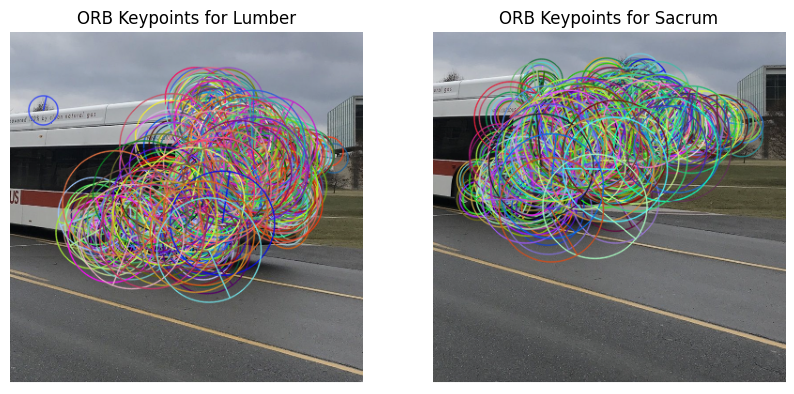

In [54]:
plt.figure(figsize=(10, 5))

# 繪製特徵點
left_img_with_keypoints = cv2.drawKeypoints(left_img, keypoints1_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # type: ignore
right_img_with_keypoints = cv2.drawKeypoints(right_img, keypoints2_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # type: ignore

plt.subplot(1, 2, 1)
plt.title('ORB Keypoints for Lumber')
plt.imshow(left_img_with_keypoints)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('ORB Keypoints for Sacrum')
plt.imshow(right_img_with_keypoints)
plt.axis('off')

plt.show()

Number of good matches: 39


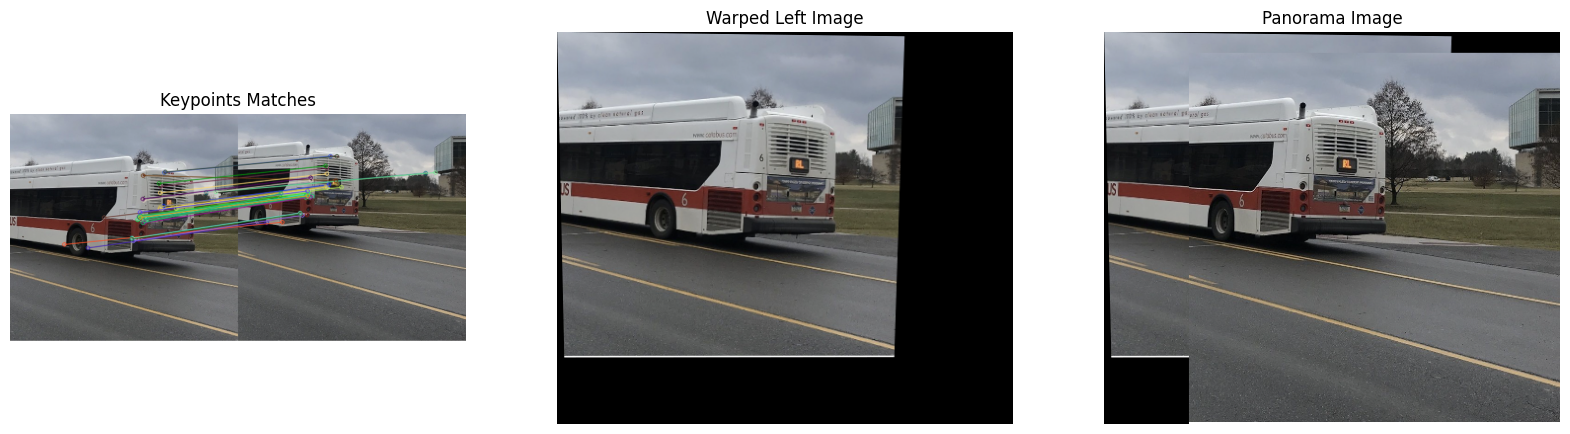

In [55]:
# 提取特徵點和描述子
keypoints1, descriptors1 = orb.detectAndCompute(left_img, mask1)
keypoints2, descriptors2 = orb.detectAndCompute(right_img, mask2)

# 特徵匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# 只保留好的匹配
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# 檢查匹配數量
print(f'Number of good matches: {len(good_matches)}')

# 提取匹配點
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore

    # 使用 RANSAC 方法估計單應矩陣
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 計算變形後的圖像邊界
    left_img_h, left_img_w = left_img.shape[:2]
    right_img_h, right_img_w = right_img.shape[:2]
    corners_left = np.float32([[0, 0], [0, left_img_h], [left_img_w, left_img_h], [left_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_right = np.float32([[0, 0], [0, right_img_h], [right_img_w, right_img_h], [right_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_left_transformed = cv2.perspectiveTransform(corners_left, H)
    corners_combined = np.concatenate((corners_right, corners_left_transformed), axis=0)

    # 找到拼接圖像的邊界
    [xmin, ymin] = np.int32(corners_combined.min(axis=0).ravel() - 0.5) # type: ignore
    [xmax, ymax] = np.int32(corners_combined.max(axis=0).ravel() + 0.5) # type: ignore

    # 計算平移變換矩陣
    translation = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    
    # 將左圖變形並平移
    warped_left_img = cv2.warpPerspective(left_img, translation.dot(H), (xmax - xmin, ymax - ymin))

    # 將右圖放置在平移後的畫布上
    result_img = warped_left_img.copy()
    result_img[-ymin:right_img_h - ymin, -xmin:right_img_w - xmin] = right_img

    # 繪製匹配點
    matches_img = cv2.drawMatches(left_img, keypoints1, right_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # type: ignore

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title('Keypoints Matches')
    plt.imshow(matches_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Warped Left Image')
    plt.imshow(warped_left_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Panorama Image')
    plt.imshow(result_img)
    plt.axis('off')

    plt.show()
else:
    print('Not enough good matches to compute homography.')

### Harris

In [56]:
# 提取 Harris 角點
def harris_corner_detector(img, mask, blockSize=2, ksize=3, k=0.04):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize, ksize, k) # type: ignore
    dst = cv2.dilate(dst, None) # type: ignore
    
    # 應用遮罩
    dst_masked = cv2.bitwise_and(dst, dst, mask=mask)
    img[dst_masked > 0.01 * dst.max()] = [0, 0, 255]
    return img

harris1 = harris_corner_detector(left_img.copy(), mask1)
harris2 = harris_corner_detector(right_img.copy(), mask2)

# 調整參數，嘗試不同的參數組合
harris1_adjusted = harris_corner_detector(left_img.copy(), mask1, blockSize=4, ksize=5, k=0.06)
harris2_adjusted = harris_corner_detector(right_img.copy(), mask2, blockSize=4, ksize=5, k=0.06)


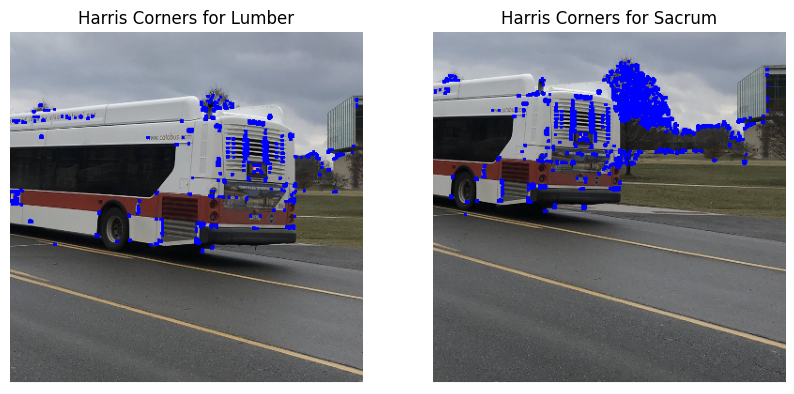

In [57]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Harris Corners for Lumber')
plt.imshow(harris1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Harris Corners for Sacrum')
plt.imshow(harris2)
plt.axis('off')

plt.show()